In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
# Define the list of stock tickers
tickers = [
    "RIVN", "TSLA", "NIO", "XPEV", "EVGO", "LI", "INDI", "CHPT", "LCID", "LAZR"
]

# Fetch data for the past three years
data = yf.download(tickers, start="2021-11-16", end="2024-11-16")

# Extract adjusted closing prices
prices = data["Adj Close"]

# Calculate daily log returns
log_returns = np.log(prices / prices.shift(1)).dropna()

[*********************100%***********************]  10 of 10 completed


## Question 6

### MLE for expected return and co-variance matrix

In [3]:
# Estimate expected return (mean) and covariance matrix
expected_return = log_returns.mean() * 252  # Annualized mean return
covariance_matrix = log_returns.cov() * 252  # Annualized covariance
expected_return, covariance_matrix

(Ticker
 CHPT   -1.069174
 EVGO   -0.369589
 INDI   -0.417623
 LAZR   -1.021408
 LCID   -1.109137
 LI     -0.122311
 NIO    -0.736494
 RIVN   -0.948839
 TSLA   -0.030701
 XPEV   -0.456968
 dtype: float64,
 Ticker      CHPT      EVGO      INDI      LAZR      LCID        LI       NIO  \
 Ticker                                                                         
 CHPT    0.715634  0.435490  0.258017  0.402502  0.374760  0.183777  0.294259   
 EVGO    0.435490  0.772066  0.220785  0.324304  0.324000  0.166139  0.264744   
 INDI    0.258017  0.220785  0.538369  0.274957  0.222106  0.130924  0.216040   
 LAZR    0.402502  0.324304  0.274957  0.874138  0.347976  0.185874  0.322517   
 LCID    0.374760  0.324000  0.222106  0.347976  0.656447  0.182350  0.320877   
 LI      0.183777  0.166139  0.130924  0.185874  0.182350  0.500034  0.374518   
 NIO     0.294259  0.264744  0.216040  0.322517  0.320877  0.374518  0.597209   
 RIVN    0.343992  0.313369  0.260342  0.352609  0.430135  0.20458

In [4]:
# Portfolio return
def portfolio_return(weights, returns):
    return np.dot(weights, returns)

# Portfolio variance
def portfolio_variance(weights, covariance):
    return np.dot(weights.T, np.dot(covariance, weights))

# Mean-Variance Optimization
def mean_variance_optimization(expected_return, covariance_matrix, num_portfolios=100):
    num_assets = len(expected_return)
    results = {"returns": [], "risks": [], "weights": []}

    for target_return in np.linspace(expected_return.min(), expected_return.max(), num_portfolios):
        constraints = (
            {"type": "eq", "fun": lambda x: np.sum(x) - 1},  # Weights sum to 1
            {"type": "eq", "fun": lambda x: portfolio_return(x, expected_return) - target_return},
        )
        bounds = [(0, 1) for _ in range(num_assets)]  # No short-selling
        initial_guess = np.ones(num_assets) / num_assets

        result = minimize(
            portfolio_variance,
            initial_guess,
            args=(covariance_matrix,),
            constraints=constraints,
            bounds=bounds,
            method="SLSQP",
        )

        if result.success:
            results["returns"].append(target_return)
            results["risks"].append(np.sqrt(result.fun))
            results["weights"].append(result.x)

    return results

In [5]:
# Calculate CVaR
def calculate_cvar(weights, log_returns, alpha=0.05):
    portfolio_returns = np.dot(log_returns, weights)
    threshold = np.percentile(portfolio_returns, alpha * 100)
    cvar = -np.mean(portfolio_returns[portfolio_returns <= threshold])
    return cvar

# CVaR Optimization
def cvar_optimization(expected_return, log_returns, alpha=0.05, num_portfolios=100):
    num_assets = len(expected_return)
    results = {"returns": [], "cvar": [], "weights": []}

    for target_return in np.linspace(expected_return.min(), expected_return.max(), num_portfolios):
        constraints = (
            {"type": "eq", "fun": lambda x: np.sum(x) - 1},  # Weights sum to 1
            {"type": "eq", "fun": lambda x: portfolio_return(x, expected_return) - target_return},
        )
        bounds = [(0, 1) for _ in range(num_assets)]  # No short-selling
        initial_guess = np.ones(num_assets) / num_assets

        result = minimize(
            calculate_cvar,
            initial_guess,
            args=(log_returns, alpha),
            constraints=constraints,
            bounds=bounds,
            method="SLSQP",
        )

        if result.success:
            results["returns"].append(target_return)
            results["cvar"].append(result.fun)
            results["weights"].append(result.x)

    return results

In [6]:
# Perform Mean-Variance Optimization
mean_variance_results = mean_variance_optimization(expected_return.to_numpy(), covariance_matrix.to_numpy())

# Perform CVaR Optimization
cvar_results = cvar_optimization(expected_return.to_numpy(), log_returns.to_numpy())

### Compare with time series prediction

#### TTM

## Question 7

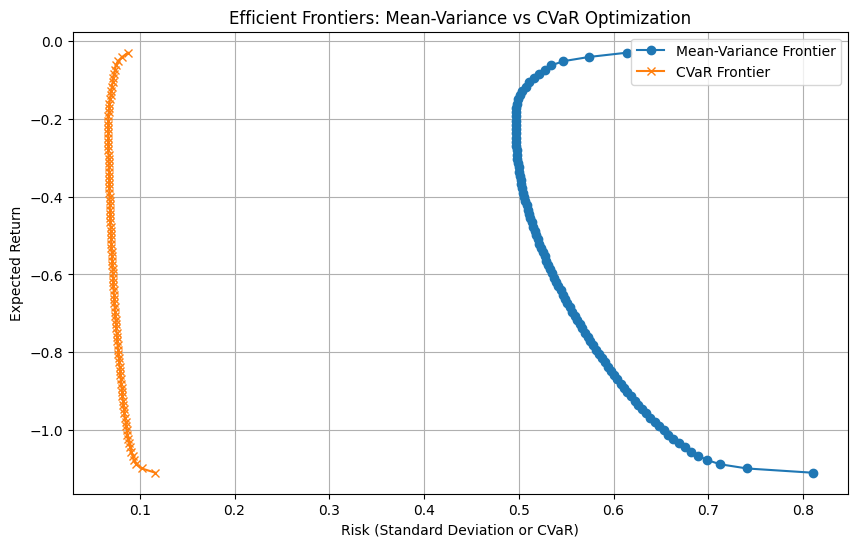

In [7]:
# Plot efficient frontiers
plt.figure(figsize=(10, 6))
plt.plot(mean_variance_results["risks"], mean_variance_results["returns"], label="Mean-Variance Frontier", marker='o')
plt.plot(cvar_results["cvar"], cvar_results["returns"], label="CVaR Frontier", marker='x')
plt.xlabel("Risk (Standard Deviation or CVaR)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontiers: Mean-Variance vs CVaR Optimization")
plt.legend()
plt.grid()
plt.show()


## Question 8

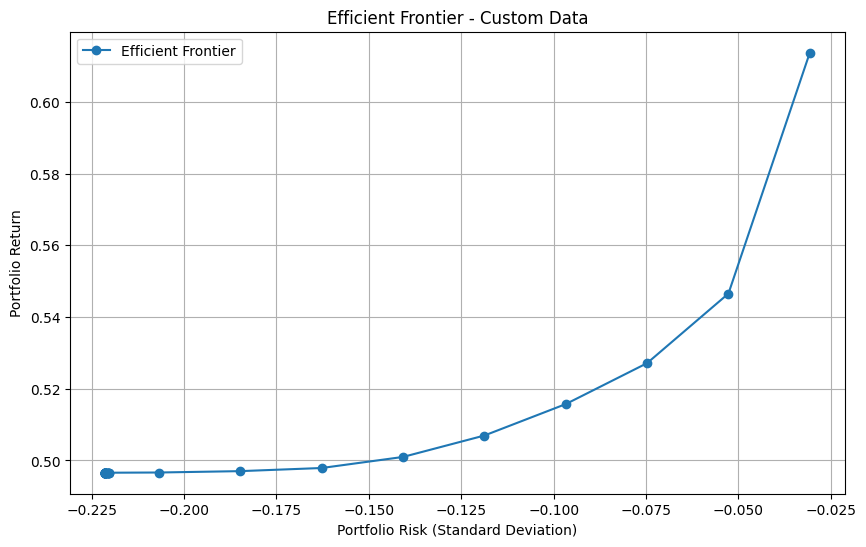

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Input: Expected returns (mean) and covariance matrix
expected_returns = pd.Series(
    {
        "CHPT": -1.069174,
        "EVGO": -0.369589,
        "INDI": -0.417623,
        "LAZR": -1.021408,
        "LCID": -1.109137,
        "LI": -0.122311,
        "NIO": -0.736494,
        "RIVN": -0.948839,
        "TSLA": -0.030701,
        "XPEV": -0.456968,
    }
)
cov_matrix = pd.DataFrame(
    {
        "CHPT": [0.715634, 0.435490, 0.258017, 0.402502, 0.374760, 0.183777, 0.294259, 0.343992, 0.214963, 0.256611],
        "EVGO": [0.435490, 0.772066, 0.220785, 0.324304, 0.324000, 0.166139, 0.264744, 0.313369, 0.176942, 0.208768],
        "INDI": [0.258017, 0.220785, 0.538369, 0.274957, 0.222106, 0.130924, 0.216040, 0.260342, 0.186899, 0.214649],
        "LAZR": [0.402502, 0.324304, 0.274957, 0.874138, 0.347976, 0.185874, 0.322517, 0.352609, 0.242249, 0.283887],
        "LCID": [0.374760, 0.324000, 0.222106, 0.347976, 0.656447, 0.182350, 0.320877, 0.430135, 0.240249, 0.295972],
        "LI": [0.183777, 0.166139, 0.130924, 0.185874, 0.182350, 0.500034, 0.374518, 0.204585, 0.143637, 0.433327],
        "NIO": [0.294259, 0.264744, 0.216040, 0.322517, 0.320877, 0.374518, 0.597209, 0.336372, 0.218301, 0.526375],
        "RIVN": [0.343992, 0.313369, 0.260342, 0.352609, 0.430135, 0.204585, 0.336372, 0.666589, 0.246542, 0.317990],
        "TSLA": [0.214963, 0.176942, 0.186899, 0.242249, 0.240249, 0.143637, 0.218301, 0.246542, 0.376678, 0.195458],
        "XPEV": [0.256611, 0.208768, 0.214649, 0.283887, 0.295972, 0.433327, 0.526375, 0.317990, 0.195458, 0.733547],
    },
    index=["CHPT", "EVGO", "INDI", "LAZR", "LCID", "LI", "NIO", "RIVN", "TSLA", "XPEV"],
)

# Risk-free rate
rf_rate = 0.03

# Function to calculate portfolio performance
def portfolio_performance(weights, returns, cov_matrix):
    port_return = np.dot(weights, returns)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return port_return, port_volatility

# Function to optimize portfolio weights
def optimize_portfolio(target_return, returns, cov_matrix):
    num_assets = len(returns)
    args = (returns, cov_matrix)

    # Constraints: Sum of weights = 1, Return >= target
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'ineq', 'fun': lambda x: np.dot(x, returns) - target_return})
    bounds = tuple((0, 1) for _ in range(num_assets))  # No short selling

    # Initial guess for weights
    init_guess = np.ones(num_assets) / num_assets

    # Minimize portfolio volatility
    result = minimize(lambda x: portfolio_performance(x, returns, cov_matrix)[1],
                      init_guess, method='SLSQP', bounds=bounds, constraints=constraints)

    return result.x

# Generate the efficient frontier
target_returns = np.linspace(expected_returns.min(), expected_returns.max(), 50)
efficient_portfolios = [
    optimize_portfolio(r, expected_returns.values, cov_matrix.values) for r in target_returns
]

# Calculate risk and return for efficient portfolios
efficient_frontier = [
    portfolio_performance(w, expected_returns.values, cov_matrix.values) for w in efficient_portfolios
]
risk, ret = zip(*efficient_frontier)

# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.plot(risk, ret, linestyle='-', marker='o', label='Efficient Frontier')
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.title('Efficient Frontier - Custom Data')
plt.legend()
plt.grid(True)
plt.show()


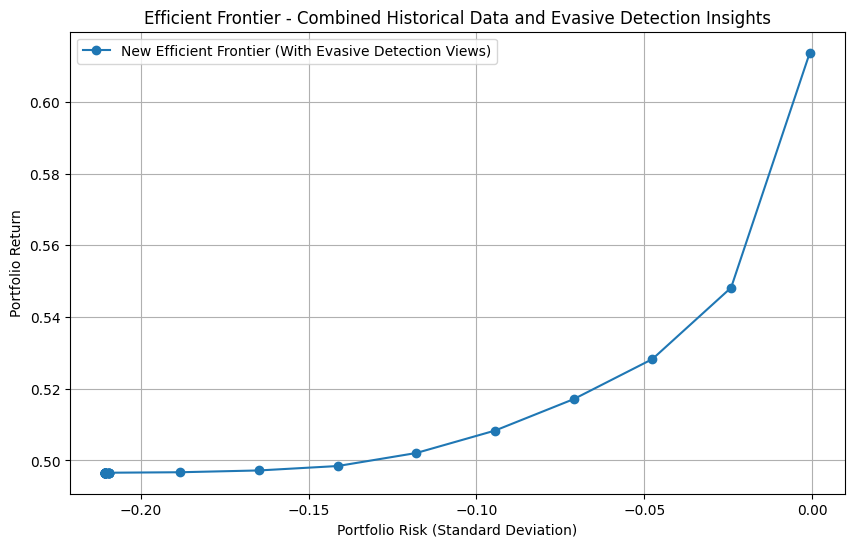

In [9]:
# Incorporate evasive detection insights as subjective views
# Adjust the expected returns based on qualitative insights

# Adjustment factors based on evasive detection prior
# (Positive adjustments for stable/mature companies, negative for risky ones)
adjustment_factors = pd.Series(
    {
        "CHPT": -0.05,
        "EVGO": -0.02,
        "INDI": -0.01,
        "LAZR": -0.03,
        "LCID": -0.04,
        "LI": 0.02,
        "NIO": -0.01,
        "RIVN": -0.03,
        "TSLA": 0.03,
        "XPEV": 0.01,
    }
)

# Combine historical data with evasive detection views
adjusted_expected_returns = expected_returns + adjustment_factors

# Generate the new efficient frontier
target_returns = np.linspace(adjusted_expected_returns.min(), adjusted_expected_returns.max(), 50)
efficient_portfolios = [
    optimize_portfolio(r, adjusted_expected_returns.values, cov_matrix.values) for r in target_returns
]

# Calculate risk and return for efficient portfolios
efficient_frontier = [
    portfolio_performance(w, adjusted_expected_returns.values, cov_matrix.values) for w in efficient_portfolios
]
risk, ret = zip(*efficient_frontier)

# Plot the updated efficient frontier
plt.figure(figsize=(10, 6))
plt.plot(risk, ret, linestyle='-', marker='o', label='New Efficient Frontier (With Evasive Detection Views)')
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.title('Efficient Frontier - Combined Historical Data and Evasive Detection Insights')
plt.legend()
plt.grid(True)
plt.show()


### Black-Litterman

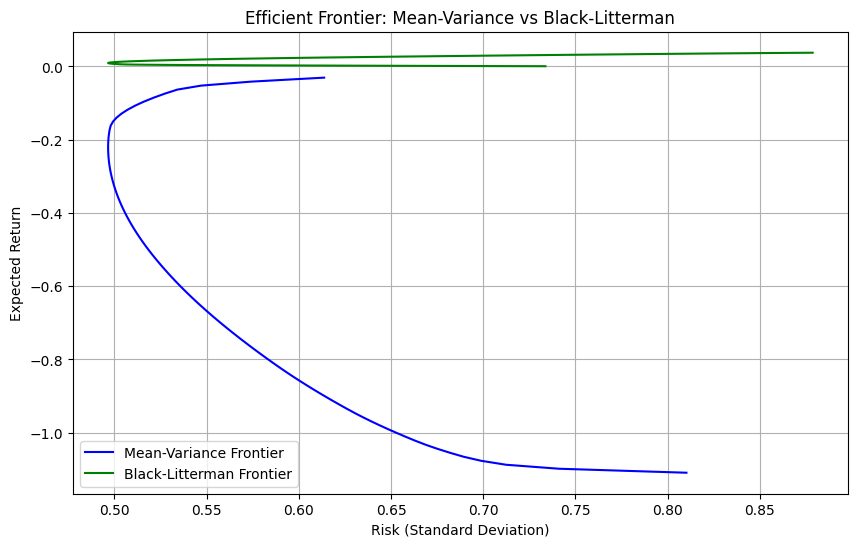

In [10]:
from scipy.optimize import minimize

# Simulating the steps since API calls are unavailable here.

# Define synthetic market cap weights for the tickers
market_caps = []
for ticker in tickers:
    stock = yf.Ticker(ticker)
    market_caps.append(stock.info['marketCap'])  # Get market cap in USD

# Convert to a NumPy array for easier operations
market_caps = np.array(market_caps)

# Calculate market weights
market_weights = market_caps / market_caps.sum()

# Tau scalar (uncertainty in equilibrium returns)
tau = 0.05

# Equilibrium returns based on market weights and covariance matrix
equilibrium_returns = tau * np.dot(covariance_matrix, market_weights)

# Define subjective views
P = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # View 1: Asset 1 outperforms by 3%
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]   # View 2: Asset 3 underperforms by 1%
])

Q = np.array([0.03, -0.01])  # Return expectations for the views

# Uncertainty in views (diagonal matrix)
Omega = np.diag([0.02, 0.02])

# Compute Black-Litterman adjusted returns
M_inverse = np.linalg.inv(tau * covariance_matrix)
P_transpose_Omega_inverse = np.dot(P.T, np.linalg.inv(Omega))
BL_inverse = np.linalg.inv(M_inverse + np.dot(P_transpose_Omega_inverse, P))
BL_returns = np.dot(
    BL_inverse,
    np.dot(M_inverse, equilibrium_returns) + np.dot(P_transpose_Omega_inverse, Q)
)

# Step 3: Calculate the efficient frontier using Black-Litterman adjusted returns
mean_variance_results_BL = mean_variance_optimization(BL_returns, covariance_matrix.to_numpy())

# Plot the efficient frontier
plt.figure(figsize=(10, 6))

# Mean-Variance Frontier
plt.plot(mean_variance_results["risks"], mean_variance_results["returns"], label="Mean-Variance Frontier", color="blue")

# Black-Litterman Frontier
plt.plot(mean_variance_results_BL["risks"], mean_variance_results_BL["returns"], label="Black-Litterman Frontier", color="green")

plt.title("Efficient Frontier: Mean-Variance vs Black-Litterman")
plt.xlabel("Risk (Standard Deviation)")
plt.ylabel("Expected Return")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
import yfinance as yf
import pandas as pd
import numpy as np

# Define the list of stock tickers and the date range
tickers = [
    "RIVN",  # Rivian Automotive
    "TSLA",  # Tesla
    "NIO",   # Nio Inc Adr
    "XPEV",  # Xpeng A Adr
    "EVGO",  # Evgo Inc
    "LI",    # Li Auto Adr
    "INDI",  # Indie Semiconductor Inc Class A
    "CHPT",  # Chargepoint Holdings Inc Class A
    "LCID",  # Lucid Group Inc
    "LAZR"   # Luminar Technologies A
]

# Fetch data for the past three years
data = yf.download(tickers, start="2021-11-16", end="2024-11-16")

# Extract adjusted closing prices
prices = data["Adj Close"]

# Calculate daily log returns
log_returns = np.log(prices / prices.shift(1)).dropna()

# Estimate expected return (mean of log returns)
expected_return = log_returns.mean()

# Estimate covariance matrix of log returns
covariance_matrix = log_returns.cov()

# Convert to annualized values (assuming 252 trading days in a year)
annualized_expected_return = expected_return * 252
annualized_covariance_matrix = covariance_matrix * 252

# Display results
print("Annualized Expected Returns:")
print(annualized_expected_return)

print("\nAnnualized Covariance Matrix:")
print(annualized_covariance_matrix)

[*********************100%***********************]  10 of 10 completed


Annualized Expected Returns:
Ticker
CHPT   -1.069174
EVGO   -0.369589
INDI   -0.417623
LAZR   -1.021408
LCID   -1.109137
LI     -0.122311
NIO    -0.736494
RIVN   -0.948839
TSLA   -0.030701
XPEV   -0.456968
dtype: float64

Annualized Covariance Matrix:
Ticker      CHPT      EVGO      INDI      LAZR      LCID        LI       NIO  \
Ticker                                                                         
CHPT    0.715634  0.435490  0.258017  0.402502  0.374760  0.183777  0.294259   
EVGO    0.435490  0.772066  0.220785  0.324304  0.324000  0.166139  0.264744   
INDI    0.258017  0.220785  0.538369  0.274957  0.222106  0.130924  0.216040   
LAZR    0.402502  0.324304  0.274957  0.874138  0.347976  0.185874  0.322517   
LCID    0.374760  0.324000  0.222106  0.347976  0.656447  0.182350  0.320877   
LI      0.183777  0.166139  0.130924  0.185874  0.182350  0.500034  0.374518   
NIO     0.294259  0.264744  0.216040  0.322517  0.320877  0.374518  0.597209   
RIVN    0.343992  0.313369  

In [12]:
data

Price                      Adj Close                                       \
Ticker                          CHPT   EVGO   INDI        LAZR       LCID   
Date                                                                        
2021-11-16 00:00:00+00:00  27.450001  15.29  15.56  312.299988  55.520000   
2021-11-17 00:00:00+00:00  27.690001  15.70  15.85  302.399994  52.549999   
2021-11-18 00:00:00+00:00  26.129999  14.58  15.60  290.700012  47.049999   
2021-11-19 00:00:00+00:00  26.900000  14.72  15.37  287.549988  55.209999   
2021-11-22 00:00:00+00:00  27.299999  13.73  14.76  277.200012  51.119999   
...                              ...    ...    ...         ...        ...   
2024-11-11 00:00:00+00:00   1.210000   5.40   5.08   15.300000   2.340000   
2024-11-12 00:00:00+00:00   1.130000   4.89   4.75   16.950001   2.140000   
2024-11-13 00:00:00+00:00   1.100000   5.20   4.73   15.750000   2.180000   
2024-11-14 00:00:00+00:00   1.120000   5.05   4.46   15.450000   2.080000   
2024-11-15 00:00:00+00:00   1.120000   5.06   4.46   14.700000   2.010000   

Price                                                                    \
Ticker                            LI        NIO        RIVN        TSLA   
Date                                                                      
2021-11-16 00:00:00+00:00  32.759998  40.669998  172.009995  351.576660   
2021-11-17 00:00:00+00:00  32.180000  39.669998  146.070007  363.003326   
2021-11-18 00:00:00+00:00  30.980000  38.410000  123.379997  365.459991   
2021-11-19 00:00:00+00:00  30.600000  38.660000  128.600006  379.019989   
2021-11-22 00:00:00+00:00  31.190001  41.490002  118.110001  385.623322   
...                              ...        ...         ...         ...   
2024-11-11 00:00:00+00:00  24.330000   5.060000   11.040000  350.000000   
2024-11-12 00:00:00+00:00  22.610001   4.580000   10.580000  328.489990   
2024-11-13 00:00:00+00:00  22.350000   4.610000   12.030000  330.239990   
2024-11-14 00:00:00+00:00  22.230000   4.430000   10.310000  311.179993   
2024-11-15 00:00:00+00:00  22.719999   4.490000   10.060000  320.720001   

Price                                 ...    Volume                     \
Ticker                          XPEV  ...      CHPT      EVGO     INDI   
Date                                  ...                                
2021-11-16 00:00:00+00:00  50.000000  ...  13851500  13046000  1915700   
2021-11-17 00:00:00+00:00  48.299999  ...  12708400  12612900  1037800   
2021-11-18 00:00:00+00:00  47.270000  ...  11027800   8224700   851400   
2021-11-19 00:00:00+00:00  46.889999  ...   6840000   4707300   885200   
2021-11-22 00:00:00+00:00  47.389999  ...  11792400   6588800  1196300   
...                              ...  ...       ...       ...      ...   
2024-11-11 00:00:00+00:00  15.300000  ...  15285100   8836600  9748700   
2024-11-12 00:00:00+00:00  13.670000  ...  13779500  25222600  4928800   
2024-11-13 00:00:00+00:00  13.350000  ...  13103900  12784500  4791300   
2024-11-14 00:00:00+00:00  12.630000  ...  14357400   6418400  4019200   
2024-11-15 00:00:00+00:00  12.740000  ...  16541500   6420000  2792200   

Price                                                                         \
Ticker                        LAZR       LCID        LI       NIO       RIVN   
Date                                                                           
2021-11-16 00:00:00+00:00   681833  248654600  14123500  37099000   94036600   
2021-11-17 00:00:00+00:00   312587  198386200   6600300  35829900   71765600   
2021-11-18 00:00:00+00:00   425973  131634800   7743500  42260200   63603600   
2021-11-19 00:00:00+00:00   288980  166718400   5672800  30069100   49479400   
2021-11-22 00:00:00+00:00   351967  130761800  10506300  70987500   40993900   
...                            ...        ...       ...       ...        ...   
2024-11-11 00:00:00+00:00  3319300  102980200   6597200  51270600   46358500   
2024-11-12 00:00:00+00:00  232092

[*********************100%***********************]  10 of 10 completed


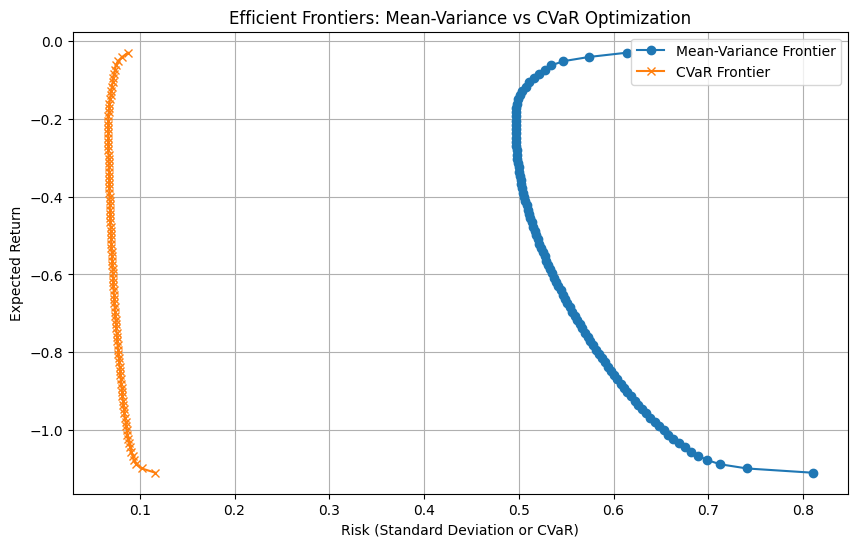

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define the list of stock tickers
tickers = [
    "RIVN", "TSLA", "NIO", "XPEV", "EVGO", "LI", "INDI", "CHPT", "LCID", "LAZR"
]

# Fetch data for the past three years
data = yf.download(tickers, start="2021-11-16", end="2024-11-16")

# Extract adjusted closing prices
prices = data["Adj Close"]

# Calculate daily log returns
log_returns = np.log(prices / prices.shift(1)).dropna()

# Annualize expected return and covariance matrix
expected_return = log_returns.mean() * 252
covariance_matrix = log_returns.cov() * 252

# Define Mean-Variance Optimization functions
def portfolio_return(weights, returns):
    return np.dot(weights, returns)

def portfolio_variance(weights, covariance):
    return np.dot(weights.T, np.dot(covariance, weights))

def mean_variance_optimization(expected_return, covariance_matrix, num_portfolios=100):
    num_assets = len(expected_return)
    results = {"returns": [], "risks": [], "weights": []}

    for target_return in np.linspace(expected_return.min(), expected_return.max(), num_portfolios):
        constraints = (
            {"type": "eq", "fun": lambda x: np.sum(x) - 1},  # Weights sum to 1
            {"type": "eq", "fun": lambda x: portfolio_return(x, expected_return) - target_return},
        )
        bounds = [(0, 1) for _ in range(num_assets)]  # No short-selling
        initial_guess = np.ones(num_assets) / num_assets

        result = minimize(
            portfolio_variance,
            initial_guess,
            args=(covariance_matrix,),
            constraints=constraints,
            bounds=bounds,
            method="SLSQP",
        )

        if result.success:
            results["returns"].append(target_return)
            results["risks"].append(np.sqrt(result.fun))
            results["weights"].append(result.x)

    return results

# Define CVaR Optimization function
def calculate_cvar(weights, log_returns, alpha=0.05):
    portfolio_returns = np.dot(log_returns, weights)
    threshold = np.percentile(portfolio_returns, alpha * 100)
    cvar = -np.mean(portfolio_returns[portfolio_returns <= threshold])
    return cvar

def cvar_optimization(expected_return, log_returns, alpha=0.05, num_portfolios=100):
    num_assets = len(expected_return)
    results = {"returns": [], "cvar": [], "weights": []}

    for target_return in np.linspace(expected_return.min(), expected_return.max(), num_portfolios):
        constraints = (
            {"type": "eq", "fun": lambda x: np.sum(x) - 1},  # Weights sum to 1
            {"type": "eq", "fun": lambda x: portfolio_return(x, expected_return) - target_return},
        )
        bounds = [(0, 1) for _ in range(num_assets)]  # No short-selling
        initial_guess = np.ones(num_assets) / num_assets

        result = minimize(
            calculate_cvar,
            initial_guess,
            args=(log_returns, alpha),
            constraints=constraints,
            bounds=bounds,
            method="SLSQP",
        )

        if result.success:
            results["returns"].append(target_return)
            results["cvar"].append(result.fun)
            results["weights"].append(result.x)

    return results

# Perform optimizations
mean_variance_results = mean_variance_optimization(expected_return.to_numpy(), covariance_matrix.to_numpy())
cvar_results = cvar_optimization(expected_return.to_numpy(), log_returns.to_numpy())

# Plot efficient frontiers
plt.figure(figsize=(10, 6))
plt.plot(mean_variance_results["risks"], mean_variance_results["returns"], label="Mean-Variance Frontier", marker='o')
plt.plot(cvar_results["cvar"], cvar_results["returns"], label="CVaR Frontier", marker='x')
plt.xlabel("Risk (Standard Deviation or CVaR)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontiers: Mean-Variance vs CVaR Optimization")
plt.legend()
plt.grid()
plt.show()

In [14]:
# objective = maximize return